In [1]:
import sys
sys.path.append('/home/andrea/Documentos/OF-PathPred/evaluation_opticalflow/lib')
import numpy as np
#from process_file import process_file_modif
#from process_file import process_file_modif_varios
#from process_file import datos_subprocesados_varios
from interseccion_process_file import process_file_modif_varios_inter
from interseccion_process_file import process_file_modif_inter
from interaction_optical_flow import OpticalFlowSimulator

import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate

In [2]:
#en marco mundo
class parameters:
    def __init__(self):
        #el numero de personas maximasdel conjunto de test
        self.person_max = 40
        #el indice del conjunto de test
        self.ind_test = 4
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = True
        self.kp_num = 18
        self.add_kp = False
        #self.directory_flujo='../evaluation_opticalflow/flujos'
arguments = parameters()

In [3]:
# Cargamos los argumentos
data_dirs = ['../data1/eth-univ', '../data1/eth-hotel',
             '../data1/ucy-zara01', '../data1/ucy-zara02',
             '../data1/ucy-univ']

#list_max_person = [42,28,22,26,68]
list_max_person_inter = [5,8,14,14,40]
data_train_and_val = process_file_modif_varios_inter(data_dirs, list_max_person_inter, arguments, ',')
print("\n\n")
dir_test = data_dirs[arguments.ind_test]
data_test = process_file_modif_inter(dir_test, arguments,',')

fo = OpticalFlowSimulator()
flujo_test, vis_neigh_test = fo.compute_opticalflow_batch(data_test['obs_person'], data_test['key_idx'], data_test['obs_traj'],arguments.obs_len)
data_test.update({
    "obs_flujo": flujo_test,
})



../data1/eth-univ/mundo/mun_pos.csv
('The numbers of examples is: ', 339)
../data1/eth-hotel/mundo/mun_pos.csv
('The numbers of examples is: ', 913)
../data1/ucy-zara01/mundo/mun_pos.csv
('The numbers of examples is: ', 2356)
../data1/ucy-zara02/mundo/mun_pos.csv
('The numbers of examples is: ', 5910)



('[INF] Sequence length: ', 20)
../data1/ucy-univ/mundo/mun_pos.csv
('El numero total de ejemplos es: ', 10039)


# We divide the data

In [4]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba


# porcentaje para el conjunto de train
prob      = 0.92
# La cantidad total de listas de tam 8 del conjunto train and test
ndata     = len(data_train_and_val[list(data_train_and_val.keys())[2]])
idx       = random.sample(range(ndata), ndata)
long1     = int(ndata*prob)
long2     = int(ndata-long1)

idx_train = idx[0:long1]
idx_val   = idx[long1:]


# conjunto de entrenamiento
data1 = {
     "obs_traj": data_train_and_val["obs_traj"][idx_train],
     "obs_traj_rel": data_train_and_val["obs_traj_rel"][idx_train],
    
     "pred_traj": data_train_and_val["pred_traj"][idx_train],
     "pred_traj_rel": data_train_and_val["pred_traj_rel"][idx_train],
    
     #"key_idx": data_entrena_vali["key_idx"][[idx_train]],
     "obs_flujo" : data_train_and_val["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}


# conjunto de validacion
data3 ={
     "obs_traj": data_train_and_val["obs_traj"][idx_val],
     "obs_traj_rel": data_train_and_val["obs_traj_rel"][idx_val],
     "pred_traj": data_train_and_val["pred_traj"][idx_val],
     "pred_traj_rel": data_train_and_val["pred_traj_rel"][idx_val],
     #"key_idx": data_entrena_vali["key_idx"][[idx_val]],
     "obs_flujo" : data_train_and_val["obs_flujo"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data_test[list(data_test.keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))


data_train: 8756
data_test: 10039
data_val: 762


#  We keep the division of the data

In [5]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_FO_UCY-UNIV_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_FO_UCY-UNIV_12.pickle","wb")
pickle.dump(data_test, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_FO_UCY-UNIV_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# Model parameters

In [6]:
class parameters1:
    def __init__(self, add_kp = None, add_social=None, train_num_examples=None):
        # -----------------
        # Similar a como se procesaron los datos
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Model training

In [7]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True, train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('FO_UCY-UNIV_NON_12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"]  = results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('FO_UCY-UNIV_NON-BEST_12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('FO_UCY-UNIV_NON_12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))


W0522 23:43:41.148148 140205703755520 deprecation.py:323] From /home/andrea/Documentos/OF-PathPred/evaluation_opticalflow/lib/model.py:60: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0522 23:43:41.183248 140205703755520 deprecation.py:323] From /home/andrea/Documentos/OF-PathPred/evaluation_opticalflow/lib/model.py:102: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0522 23:43:41.271322 140205703755520 deprecation.py:506] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions f

438
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/39 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 39/39 [00:01<00:00, 31.96it/s]

{'ade': 1.7567339, 'fde': 3.2276096}
	 last loss:-1.000000000, eval on validation:['ade: 1.7567339', 'fde: 3.2276096'], (best ade:999999 at step -1) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 300...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 70.41it/s]

{'ade': 0.44236526, 'fde': 0.9773553}
	 last loss:0.000576989, eval on validation:['ade: 0.44236526', 'fde: 0.9773553'], (best ade:1.7567339 at step 1) 
	 saving best model...
	 done.


  0%|          | 1/438 [00:00<00:48,  9.06it/s]

('Epoca 2.', 'lr:', 0.002)


 37%|███▋      | 160/438 [00:06<00:10, 26.33it/s]W0522 23:44:13.172861 140205703755520 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



 37%|███▋      | 163/438 [00:07<00:31,  8.64it/s]A

{'ade': 0.5221263, 'fde': 1.1997651}
	 last loss:0.000671476, eval on validation:['ade: 0.5221263', 'fde: 1.1997651'], (best ade:0.44236526 at step 300) 


  0%|          | 1/438 [00:00<00:50,  8.73it/s]

('Epoca 3.', 'lr:', 0.0017000001)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 900...
	done
Evaluating



  5%|▌         | 24/438 [00:01<00:50,  8.14it/s][A

{'ade': 0.43385994, 'fde': 0.9490241}
	 last loss:0.000658395, eval on validation:['ade: 0.43385994', 'fde: 0.9490241'], (best ade:0.44236526 at step 300) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 1200...
	done
Evaluating



 74%|███████▍  | 325/438 [00:15<00:11,  9.47it/s]A

{'ade': 0.45861614, 'fde': 1.0379097}
	 last loss:0.000362820, eval on validation:['ade: 0.45861614', 'fde: 1.0379097'], (best ade:0.43385994 at step 900) 


  0%|          | 1/438 [00:00<00:47,  9.11it/s]

('Epoca 4.', 'lr:', 0.0017000001)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 1500...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 79.23it/s]

{'ade': 0.42758986, 'fde': 0.93570065}
	 last loss:0.000613294, eval on validation:['ade: 0.42758986', 'fde: 0.93570065'], (best ade:0.43385994 at step 900) 
	 saving best model...
	 done.


  1%|          | 3/438 [00:00<00:19, 22.81it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 1800...
	done
Evaluating



 12%|█▏        | 51/438 [00:02<00:34, 11.12it/s][A

{'ade': 0.45592365, 'fde': 1.0179207}
	 last loss:0.000316918, eval on validation:['ade: 0.45592365', 'fde: 1.0179207'], (best ade:0.42758986 at step 1500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 2100...
	done
Evaluating



 79%|███████▉  | 348/438 [00:15<00:10,  8.35it/s]A

{'ade': 0.40091667, 'fde': 0.8783156}
	 last loss:0.000586835, eval on validation:['ade: 0.40091667', 'fde: 0.8783156'], (best ade:0.42758986 at step 1500) 
	 saving best model...
	 done.


  0%|          | 2/438 [00:00<00:22, 19.21it/s]

('Epoca 6.', 'lr:', 0.0014450002)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 2400...
	done
Evaluating



 48%|████▊     | 212/438 [00:09<00:23,  9.44it/s]A

{'ade': 0.4961952, 'fde': 1.1565163}
	 last loss:0.000953057, eval on validation:['ade: 0.4961952', 'fde: 1.1565163'], (best ade:0.40091667 at step 2100) 


  0%|          | 2/438 [00:00<00:28, 15.30it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 2700...
	done
Evaluating



 17%|█▋        | 74/438 [00:03<00:39,  9.32it/s][A

{'ade': 0.4775956, 'fde': 1.0707508}
	 last loss:0.000556887, eval on validation:['ade: 0.4775956', 'fde: 1.0707508'], (best ade:0.40091667 at step 2100) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 3000...
	done
Evaluating



 85%|████████▌ | 374/438 [00:16<00:06,  9.85it/s]A

{'ade': 0.4814498, 'fde': 1.0638722}
	 last loss:0.000539761, eval on validation:['ade: 0.4814498', 'fde: 1.0638722'], (best ade:0.40091667 at step 2100) 


  0%|          | 1/438 [00:00<00:46,  9.32it/s]

('Epoca 8.', 'lr:', 0.0012282502)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 3300...
	done
Evaluating



 54%|█████▎    | 235/438 [00:10<00:22,  9.08it/s]A

{'ade': 0.41237193, 'fde': 0.9061829}
	 last loss:0.000485015, eval on validation:['ade: 0.41237193', 'fde: 0.9061829'], (best ade:0.40091667 at step 2100) 


  1%|          | 3/438 [00:00<00:18, 23.95it/s]

('Epoca 9.', 'lr:', 0.0010440127)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 3600...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 87.93it/s]

{'ade': 0.398357, 'fde': 0.85962117}
	 last loss:0.000342017, eval on validation:['ade: 0.398357', 'fde: 0.85962117'], (best ade:0.40091667 at step 2100) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 3900...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 79.12it/s]

{'ade': 0.3911205, 'fde': 0.85099787}
	 last loss:0.000460456, eval on validation:['ade: 0.3911205', 'fde: 0.85099787'], (best ade:0.398357 at step 3600) 
	 saving best model...
	 done.


  0%|          | 1/438 [00:00<00:51,  8.48it/s]

('Epoca 10.', 'lr:', 0.0010440127)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 4200...
	done
Evaluating



 60%|█████▉    | 261/438 [00:11<00:14, 11.83it/s]A

{'ade': 0.40375257, 'fde': 0.89002055}
	 last loss:0.000559232, eval on validation:['ade: 0.40375257', 'fde: 0.89002055'], (best ade:0.3911205 at step 3900) 


  0%|          | 1/438 [00:00<00:50,  8.70it/s]

('Epoca 11.', 'lr:', 0.0008874108)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 4500...
	done
Evaluating



 28%|██▊       | 124/438 [00:05<00:26, 12.02it/s]A

{'ade': 0.39538124, 'fde': 0.874849}
	 last loss:0.000349494, eval on validation:['ade: 0.39538124', 'fde: 0.874849'], (best ade:0.3911205 at step 3900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 4800...
	done
Evaluating



 96%|█████████▌| 421/438 [00:18<00:01,  9.17it/s]A

{'ade': 0.39234468, 'fde': 0.85870665}
	 last loss:0.000580915, eval on validation:['ade: 0.39234468', 'fde: 0.85870665'], (best ade:0.3911205 at step 3900) 


  1%|          | 3/438 [00:00<00:19, 21.87it/s]

('Epoca 12.', 'lr:', 0.0008874108)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 5100...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 83.47it/s]

{'ade': 0.38742632, 'fde': 0.8265152}
	 last loss:0.000356636, eval on validation:['ade: 0.38742632', 'fde: 0.8265152'], (best ade:0.3911205 at step 3900) 
	 saving best model...
	 done.


  0%|          | 1/438 [00:00<00:44,  9.88it/s]

('Epoca 13.', 'lr:', 0.0007542992)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 5400...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 78.68it/s]

{'ade': 0.36931637, 'fde': 0.80397224}
	 last loss:0.000211188, eval on validation:['ade: 0.36931637', 'fde: 0.80397224'], (best ade:0.38742632 at step 5100) 
	 saving best model...
	 done.


  1%|          | 3/438 [00:00<00:19, 22.48it/s]

('Epoca 14.', 'lr:', 0.0007542992)



  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 5700...
	done
Evaluating



  2%|▏         | 9/438 [00:01<00:37, 11.38it/s]

{'ade': 0.41558328, 'fde': 0.928419}
	 last loss:0.000353020, eval on validation:['ade: 0.41558328', 'fde: 0.928419'], (best ade:0.36931637 at step 5400) 


 70%|██████▉   | 305/438 [00:15<00:07, 18.45it/s]

	saving model 6000...



 18%|#7        | 7/39 [00:00<00:00, 62.28it/s]

	done
Evaluating



 70%|███████   | 307/438 [00:16<00:27,  4.71it/s]A

{'ade': 0.40190214, 'fde': 0.89870167}
	 last loss:0.000484638, eval on validation:['ade: 0.40190214', 'fde: 0.89870167'], (best ade:0.36931637 at step 5400) 


  0%|          | 1/438 [00:00<00:51,  8.56it/s]

('Epoca 15.', 'lr:', 0.0006411543)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 6300...
	done
Evaluating



 39%|███▊      | 169/438 [00:07<00:31,  8.58it/s]A

{'ade': 0.39045808, 'fde': 0.85887885}
	 last loss:0.000412599, eval on validation:['ade: 0.39045808', 'fde: 0.85887885'], (best ade:0.36931637 at step 5400) 


  1%|          | 3/438 [00:00<00:16, 26.17it/s]

('Epoca 16.', 'lr:', 0.0006411543)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 6600...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 93.72it/s]

{'ade': 0.3672341, 'fde': 0.7928684}
	 last loss:0.000476692, eval on validation:['ade: 0.3672341', 'fde: 0.7928684'], (best ade:0.36931637 at step 5400) 
	 saving best model...
	 done.


 75%|███████▍  | 328/438 [00:14<00:07, 15.49it/s]

	saving model 6900...



 10%|#         | 4/39 [00:00<00:00, 38.83it/s]

	done
Evaluating



 75%|███████▌  | 330/438 [00:16<00:28,  3.77it/s]A

{'ade': 0.36812893, 'fde': 0.7872659}
	 last loss:0.000324075, eval on validation:['ade: 0.36812893', 'fde: 0.7872659'], (best ade:0.3672341 at step 6600) 


  0%|          | 1/438 [00:00<00:46,  9.31it/s]

('Epoca 17.', 'lr:', 0.0005449812)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 7200...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 85.18it/s]

{'ade': 0.36201143, 'fde': 0.7774394}
	 last loss:0.000526685, eval on validation:['ade: 0.36201143', 'fde: 0.7774394'], (best ade:0.3672341 at step 6600) 
	 saving best model...
	 done.


  0%|          | 1/438 [00:00<00:45,  9.70it/s]

('Epoca 18.', 'lr:', 0.0005449812)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 7500...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 60.00it/s]

{'ade': 0.35868323, 'fde': 0.7742848}
	 last loss:0.000320175, eval on validation:['ade: 0.35868323', 'fde: 0.7742848'], (best ade:0.36201143 at step 7200) 
	 saving best model...


 13%|█▎        | 56/438 [00:03<00:46,  8.14it/s]

	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 7800...
	done
Evaluating



 82%|████████▏ | 358/438 [00:18<00:06, 11.91it/s]A

{'ade': 0.37467742, 'fde': 0.79135954}
	 last loss:0.000542236, eval on validation:['ade: 0.37467742', 'fde: 0.79135954'], (best ade:0.35868323 at step 7500) 


  0%|          | 1/438 [00:00<00:46,  9.33it/s]

('Epoca 19.', 'lr:', 0.00046323403)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 8100...
	done
Evaluating



 50%|█████     | 219/438 [00:09<00:19, 11.08it/s]A

{'ade': 0.3924505, 'fde': 0.8529921}
	 last loss:0.000199067, eval on validation:['ade: 0.3924505', 'fde: 0.8529921'], (best ade:0.35868323 at step 7500) 


  0%|          | 1/438 [00:00<00:52,  8.35it/s]

('Epoca 20.', 'lr:', 0.00046323403)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 8400...
	done
Evaluating



 19%|█▊        | 82/438 [00:03<00:29, 12.01it/s][A

{'ade': 0.36170217, 'fde': 0.77991796}
	 last loss:0.000248839, eval on validation:['ade: 0.36170217', 'fde: 0.77991796'], (best ade:0.35868323 at step 7500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 8700...
	done
Evaluating



 87%|████████▋ | 379/438 [00:16<00:06,  9.08it/s]A

{'ade': 0.3739212, 'fde': 0.7922541}
	 last loss:0.000708197, eval on validation:['ade: 0.3739212', 'fde: 0.7922541'], (best ade:0.35868323 at step 7500) 


  0%|          | 2/438 [00:00<00:22, 19.29it/s]

('Epoca 21.', 'lr:', 0.00039374892)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 9000...
	done
Evaluating



 55%|█████▌    | 241/438 [00:11<00:25,  7.78it/s]A

{'ade': 0.35881516, 'fde': 0.7580665}
	 last loss:0.000344931, eval on validation:['ade: 0.35881516', 'fde: 0.7580665'], (best ade:0.35868323 at step 7500) 


  0%|          | 2/438 [00:00<00:31, 13.76it/s]

('Epoca 22.', 'lr:', 0.00039374892)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 9300...
	done
Evaluating



 24%|██▎       | 104/438 [00:05<00:37,  8.99it/s]A

{'ade': 0.36744243, 'fde': 0.7890627}
	 last loss:0.000539566, eval on validation:['ade: 0.36744243', 'fde: 0.7890627'], (best ade:0.35868323 at step 7500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 9600...
	done
Evaluating



 92%|█████████▏| 405/438 [00:19<00:02, 12.65it/s]A

{'ade': 0.368627, 'fde': 0.7995897}
	 last loss:0.000382855, eval on validation:['ade: 0.368627', 'fde: 0.7995897'], (best ade:0.35868323 at step 7500) 


  0%|          | 1/438 [00:00<00:48,  9.03it/s]

('Epoca 23.', 'lr:', 0.0003346866)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 9900...
	done
Evaluating



 61%|██████    | 266/438 [00:12<00:20,  8.46it/s]A

{'ade': 0.3624931, 'fde': 0.7776674}
	 last loss:0.000449756, eval on validation:['ade: 0.3624931', 'fde: 0.7776674'], (best ade:0.35868323 at step 7500) 


  0%|          | 2/438 [00:00<00:30, 14.46it/s]

('Epoca 24.', 'lr:', 0.0003346866)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 10200...
	done
Evaluating



 30%|██▉       | 130/438 [00:06<00:26, 11.56it/s]A

{'ade': 0.37396768, 'fde': 0.8143972}
	 last loss:0.000622162, eval on validation:['ade: 0.37396768', 'fde: 0.8143972'], (best ade:0.35868323 at step 7500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 10500...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 85.43it/s]

{'ade': 0.3584699, 'fde': 0.77261984}
	 last loss:0.000399701, eval on validation:['ade: 0.3584699', 'fde: 0.77261984'], (best ade:0.35868323 at step 7500) 
	 saving best model...
	 done.


  1%|          | 3/438 [00:00<00:17, 24.77it/s]

('Epoca 25.', 'lr:', 0.00028448363)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 10800...
	done
Evaluating



 66%|██████▋   | 291/438 [00:11<00:11, 12.78it/s]A

{'ade': 0.36170435, 'fde': 0.78521395}
	 last loss:0.000178399, eval on validation:['ade: 0.36170435', 'fde: 0.78521395'], (best ade:0.3584699 at step 10500) 


  0%|          | 1/438 [00:00<00:49,  8.87it/s]

('Epoca 26.', 'lr:', 0.00028448363)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 11100...
	done
Evaluating



 35%|███▌      | 154/438 [00:06<00:23, 11.93it/s]A

{'ade': 0.35885307, 'fde': 0.77281505}
	 last loss:0.000456187, eval on validation:['ade: 0.35885307', 'fde: 0.77281505'], (best ade:0.3584699 at step 10500) 


  0%|          | 1/438 [00:00<00:51,  8.57it/s]

('Epoca 27.', 'lr:', 0.0002418111)


  2%|▏         | 9/438 [00:00<00:30, 13.97it/s]

	saving model 11400...



 21%|##        | 8/39 [00:00<00:00, 71.52it/s]

	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 67.00it/s]

{'ade': 0.35255945, 'fde': 0.7506834}
	 last loss:0.000472916, eval on validation:['ade: 0.35255945', 'fde: 0.7506834'], (best ade:0.3584699 at step 10500) 
	 saving best model...


  3%|▎         | 15/438 [00:01<00:54,  7.69it/s]

	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 11700...
	done
Evaluating



 71%|███████▏  | 313/438 [00:15<00:18,  6.71it/s]A

{'ade': 0.37453836, 'fde': 0.81850195}
	 last loss:0.000840686, eval on validation:['ade: 0.37453836', 'fde: 0.81850195'], (best ade:0.35255945 at step 11400) 


  0%|          | 2/438 [00:00<00:25, 17.00it/s]

('Epoca 28.', 'lr:', 0.0002418111)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 12000...
	done
Evaluating



 40%|████      | 176/438 [00:07<00:28,  9.33it/s]A

{'ade': 0.37108895, 'fde': 0.8002901}
	 last loss:0.000357004, eval on validation:['ade: 0.37108895', 'fde: 0.8002901'], (best ade:0.35255945 at step 11400) 


  0%|          | 2/438 [00:00<00:30, 14.51it/s]

('Epoca 29.', 'lr:', 0.00020553943)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 12300...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 66.60it/s]

{'ade': 0.35057494, 'fde': 0.738927}
	 last loss:0.000387838, eval on validation:['ade: 0.35057494', 'fde: 0.738927'], (best ade:0.35255945 at step 11400) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 12600...
	done
Evaluating



 77%|███████▋  | 339/438 [00:17<00:08, 11.66it/s]A

{'ade': 0.35289422, 'fde': 0.7610014}
	 last loss:0.000404425, eval on validation:['ade: 0.35289422', 'fde: 0.7610014'], (best ade:0.35057494 at step 12300) 


  1%|          | 3/438 [00:00<00:19, 22.74it/s]

('Epoca 30.', 'lr:', 0.00020553943)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 12900...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 78.08it/s]

{'ade': 0.34834313, 'fde': 0.74325895}
	 last loss:0.000189456, eval on validation:['ade: 0.34834313', 'fde: 0.74325895'], (best ade:0.35057494 at step 12300) 
	 saving best model...
	 done.


  0%|          | 1/438 [00:00<00:56,  7.68it/s]

('Epoca 31.', 'lr:', 0.00017470852)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 13200...
	done
Evaluating



 14%|█▍        | 62/438 [00:03<00:42,  8.79it/s][A

{'ade': 0.3545993, 'fde': 0.7560034}
	 last loss:0.000359289, eval on validation:['ade: 0.3545993', 'fde: 0.7560034'], (best ade:0.34834313 at step 12900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 13500...
	done
Evaluating



 82%|████████▏ | 361/438 [00:16<00:08,  9.01it/s]A

{'ade': 0.34944898, 'fde': 0.7454765}
	 last loss:0.000333841, eval on validation:['ade: 0.34944898', 'fde: 0.7454765'], (best ade:0.34834313 at step 12900) 


  1%|          | 3/438 [00:00<00:19, 22.88it/s]

('Epoca 32.', 'lr:', 0.00017470852)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 13800...
	done
Evaluating



 51%|█████▏    | 225/438 [00:09<00:17, 12.22it/s]A

{'ade': 0.36530966, 'fde': 0.7936278}
	 last loss:0.000320483, eval on validation:['ade: 0.36530966', 'fde: 0.7936278'], (best ade:0.34834313 at step 12900) 


  0%|          | 2/438 [00:00<00:25, 16.90it/s]

('Epoca 33.', 'lr:', 0.00014850224)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 14100...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 77.11it/s]

{'ade': 0.34448102, 'fde': 0.73893934}
	 last loss:0.000499979, eval on validation:['ade: 0.34448102', 'fde: 0.73893934'], (best ade:0.34834313 at step 12900) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 14400...
	done
Evaluating



 89%|████████▊ | 388/438 [00:18<00:04, 11.09it/s]A

{'ade': 0.36693963, 'fde': 0.793379}
	 last loss:0.000628582, eval on validation:['ade: 0.36693963', 'fde: 0.793379'], (best ade:0.34448102 at step 14100) 


  0%|          | 2/438 [00:00<00:26, 16.61it/s]

('Epoca 34.', 'lr:', 0.00014850224)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 14700...
	done
Evaluating



 57%|█████▋    | 249/438 [00:11<00:17, 10.98it/s]A

{'ade': 0.3470914, 'fde': 0.7407518}
	 last loss:0.000465812, eval on validation:['ade: 0.3470914', 'fde: 0.7407518'], (best ade:0.34448102 at step 14100) 


  0%|          | 1/438 [00:00<00:46,  9.42it/s]

('Epoca 35.', 'lr:', 0.0001262269)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 15000...
	done
Evaluating



 26%|██▌       | 112/438 [00:05<00:27, 11.79it/s]A

{'ade': 0.3495206, 'fde': 0.7536454}
	 last loss:0.000169870, eval on validation:['ade: 0.3495206', 'fde: 0.7536454'], (best ade:0.34448102 at step 14100) 


 93%|█████████▎| 407/438 [00:17<00:01, 20.76it/s]

	saving model 15300...



 21%|##        | 8/39 [00:00<00:00, 73.86it/s]

	done
Evaluating



 94%|█████████▎| 410/438 [00:18<00:03,  8.31it/s]A

{'ade': 0.35041806, 'fde': 0.75373006}
	 last loss:0.000422838, eval on validation:['ade: 0.35041806', 'fde: 0.75373006'], (best ade:0.34448102 at step 14100) 


  0%|          | 1/438 [00:00<00:48,  9.09it/s]

('Epoca 36.', 'lr:', 0.0001262269)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 15600...
	done
Evaluating



 62%|██████▏   | 271/438 [00:11<00:17,  9.31it/s]A

{'ade': 0.3547076, 'fde': 0.76007193}
	 last loss:0.000584879, eval on validation:['ade: 0.3547076', 'fde: 0.76007193'], (best ade:0.34448102 at step 14100) 


  0%|          | 1/438 [00:00<00:50,  8.74it/s]

('Epoca 37.', 'lr:', 0.00010729288)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 15900...
	done
Evaluating



 30%|███       | 133/438 [00:05<00:31,  9.76it/s]A

{'ade': 0.34453192, 'fde': 0.73873395}
	 last loss:0.000329254, eval on validation:['ade: 0.34453192', 'fde: 0.73873395'], (best ade:0.34448102 at step 14100) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 16200...
	done
Evaluating



 99%|█████████▉| 435/438 [00:19<00:00, 12.36it/s]A

{'ade': 0.34832034, 'fde': 0.74589044}
	 last loss:0.000353319, eval on validation:['ade: 0.34832034', 'fde: 0.74589044'], (best ade:0.34448102 at step 14100) 


  0%|          | 1/438 [00:00<00:44,  9.72it/s]

('Epoca 38.', 'lr:', 0.00010729288)


 67%|██████▋   | 292/438 [00:13<00:08, 16.83it/s]

	saving model 16500...



 15%|#5        | 6/39 [00:00<00:00, 57.59it/s]

	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 51.20it/s]

{'ade': 0.33880028, 'fde': 0.7239075}
	 last loss:0.000417249, eval on validation:['ade: 0.33880028', 'fde: 0.7239075'], (best ade:0.34448102 at step 14100) 
	 saving best model...
	 done.


  0%|          | 2/438 [00:00<00:22, 19.76it/s]

('Epoca 39.', 'lr:', 9.119895e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 16800...
	done
Evaluating



 36%|███▌      | 157/438 [00:07<00:31,  8.92it/s]A

{'ade': 0.34224668, 'fde': 0.7295385}
	 last loss:0.000531568, eval on validation:['ade: 0.34224668', 'fde: 0.7295385'], (best ade:0.33880028 at step 16500) 


  0%|          | 1/438 [00:00<00:52,  8.36it/s]

('Epoca 40.', 'lr:', 9.119895e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 17100...
	done
Evaluating



  5%|▍         | 21/438 [00:01<00:37, 11.21it/s][A

{'ade': 0.34308428, 'fde': 0.7265135}
	 last loss:0.000487994, eval on validation:['ade: 0.34308428', 'fde: 0.7265135'], (best ade:0.33880028 at step 16500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 17400...
	done
Evaluating



 73%|███████▎  | 321/438 [00:15<00:14,  7.97it/s]A

{'ade': 0.34389716, 'fde': 0.73523253}
	 last loss:0.000447287, eval on validation:['ade: 0.34389716', 'fde: 0.73523253'], (best ade:0.33880028 at step 16500) 


  0%|          | 1/438 [00:00<00:50,  8.67it/s]

('Epoca 41.', 'lr:', 7.751911e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 17700...
	done
Evaluating



 41%|████▏     | 181/438 [00:08<00:28,  8.92it/s]A

{'ade': 0.35377836, 'fde': 0.76213133}
	 last loss:0.000351338, eval on validation:['ade: 0.35377836', 'fde: 0.76213133'], (best ade:0.33880028 at step 16500) 


  0%|          | 1/438 [00:00<00:48,  9.04it/s]

('Epoca 42.', 'lr:', 7.751911e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 18000...
	done
Evaluating



 11%|█         | 46/438 [00:02<00:35, 11.03it/s][A

{'ade': 0.34654492, 'fde': 0.7387959}
	 last loss:0.000182781, eval on validation:['ade: 0.34654492', 'fde: 0.7387959'], (best ade:0.33880028 at step 16500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 18300...
	done
Evaluating



 78%|███████▊  | 343/438 [00:16<00:11,  8.51it/s]A

{'ade': 0.3444821, 'fde': 0.7353764}
	 last loss:0.000435102, eval on validation:['ade: 0.3444821', 'fde: 0.7353764'], (best ade:0.33880028 at step 16500) 


  0%|          | 1/438 [00:00<00:49,  8.82it/s]

('Epoca 43.', 'lr:', 6.589125e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 18600...
	done
Evaluating



 47%|████▋     | 205/438 [00:09<00:25,  9.04it/s]A

{'ade': 0.3429531, 'fde': 0.73492545}
	 last loss:0.000426465, eval on validation:['ade: 0.3429531', 'fde: 0.73492545'], (best ade:0.33880028 at step 16500) 


  0%|          | 2/438 [00:00<00:34, 12.64it/s]

('Epoca 44.', 'lr:', 6.589125e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 18900...
	done
Evaluating



 15%|█▌        | 67/438 [00:04<00:46,  8.01it/s][A

{'ade': 0.34337485, 'fde': 0.7355883}
	 last loss:0.000345636, eval on validation:['ade: 0.34337485', 'fde: 0.7355883'], (best ade:0.33880028 at step 16500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 19200...
	done
Evaluating



 84%|████████▍ | 370/438 [00:17<00:05, 12.28it/s]A

{'ade': 0.34961617, 'fde': 0.7485978}
	 last loss:0.000327043, eval on validation:['ade: 0.34961617', 'fde: 0.7485978'], (best ade:0.33880028 at step 16500) 


  0%|          | 2/438 [00:00<00:29, 14.68it/s]

('Epoca 45.', 'lr:', 5.600756e-05)


 52%|█████▏    | 226/438 [00:10<00:08, 24.53it/s]

	saving model 19500...



 21%|##        | 8/39 [00:00<00:00, 76.57it/s]

	done
Evaluating



 53%|█████▎    | 232/438 [00:11<00:19, 10.82it/s]A

{'ade': 0.34258685, 'fde': 0.73172325}
	 last loss:0.000284059, eval on validation:['ade: 0.34258685', 'fde: 0.73172325'], (best ade:0.33880028 at step 16500) 


  0%|          | 1/438 [00:00<00:53,  8.14it/s]

('Epoca 46.', 'lr:', 5.600756e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 19800...
	done
Evaluating



 21%|██        | 92/438 [00:04<00:40,  8.59it/s][A

{'ade': 0.34305233, 'fde': 0.7325108}
	 last loss:0.000336412, eval on validation:['ade: 0.34305233', 'fde: 0.7325108'], (best ade:0.33880028 at step 16500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 20100...
	done
Evaluating



 89%|████████▉ | 391/438 [00:18<00:05,  9.19it/s]A

{'ade': 0.34381145, 'fde': 0.73245573}
	 last loss:0.000375167, eval on validation:['ade: 0.34381145', 'fde: 0.73245573'], (best ade:0.33880028 at step 16500) 


  1%|          | 3/438 [00:00<00:18, 22.95it/s]

('Epoca 47.', 'lr:', 4.7606427e-05)


 57%|█████▋    | 250/438 [00:10<00:10, 17.74it/s]

	saving model 20400...



 18%|#7        | 7/39 [00:00<00:00, 67.18it/s]

	done
Evaluating



 58%|█████▊    | 252/438 [00:11<00:36,  5.16it/s]A

{'ade': 0.33895826, 'fde': 0.72091156}
	 last loss:0.000181316, eval on validation:['ade: 0.33895826', 'fde: 0.72091156'], (best ade:0.33880028 at step 16500) 


  0%|          | 2/438 [00:00<00:27, 16.02it/s]

('Epoca 48.', 'lr:', 4.7606427e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 20700...
	done
Evaluating



 26%|██▋       | 115/438 [00:05<00:33,  9.51it/s]A

{'ade': 0.34157863, 'fde': 0.72890323}
	 last loss:0.000254020, eval on validation:['ade: 0.34157863', 'fde: 0.72890323'], (best ade:0.33880028 at step 16500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 21000...
	done
Evaluating



 95%|█████████▍| 415/438 [00:18<00:02,  9.55it/s]A

{'ade': 0.33971536, 'fde': 0.72708833}
	 last loss:0.000247775, eval on validation:['ade: 0.33971536', 'fde: 0.72708833'], (best ade:0.33880028 at step 16500) 


  0%|          | 1/438 [00:00<00:43,  9.99it/s]

('Epoca 49.', 'lr:', 4.0465464e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 21300...
	done
Evaluating



 63%|██████▎   | 277/438 [00:12<00:18,  8.88it/s]A

{'ade': 0.33956787, 'fde': 0.72468114}
	 last loss:0.000227966, eval on validation:['ade: 0.33956787', 'fde: 0.72468114'], (best ade:0.33880028 at step 16500) 


  0%|          | 1/438 [00:00<00:50,  8.66it/s]

('Epoca 50.', 'lr:', 4.0465464e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 21600...
	done
Evaluating



 32%|███▏      | 139/438 [00:06<00:32,  9.24it/s]A

{'ade': 0.33899197, 'fde': 0.72096014}
	 last loss:0.000313431, eval on validation:['ade: 0.33899197', 'fde: 0.72096014'], (best ade:0.33880028 at step 16500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 21900...
	done
Evaluating



  0%|          | 0/438 [00:00<?, ?it/s]

{'ade': 0.3394928, 'fde': 0.7248079}
	 last loss:0.000453083, eval on validation:['ade: 0.3394928', 'fde: 0.7248079'], (best ade:0.33880028 at step 16500) 
('Epoca 51.', 'lr:', 3.4395645e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 22200...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 78.80it/s]

{'ade': 0.33876625, 'fde': 0.7206765}
	 last loss:0.000655027, eval on validation:['ade: 0.33876625', 'fde: 0.7206765'], (best ade:0.33880028 at step 16500) 
	 saving best model...
	 done.


  1%|          | 3/438 [00:00<00:20, 21.14it/s]

('Epoca 52.', 'lr:', 3.4395645e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 22500...
	done
Evaluating



 38%|███▊      | 165/438 [00:07<00:23, 11.57it/s]A

{'ade': 0.34518337, 'fde': 0.73925626}
	 last loss:0.000684364, eval on validation:['ade: 0.34518337', 'fde: 0.73925626'], (best ade:0.33876625 at step 22200) 


  0%|          | 1/438 [00:00<00:49,  8.86it/s]

('Epoca 53.', 'lr:', 2.92363e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 22800...
	done
Evaluating



  6%|▌         | 27/438 [00:01<00:36, 11.19it/s][A

{'ade': 0.3412208, 'fde': 0.7296844}
	 last loss:0.000390687, eval on validation:['ade: 0.3412208', 'fde: 0.7296844'], (best ade:0.33876625 at step 22200) 


 74%|███████▎  | 322/438 [00:15<00:08, 13.31it/s]


	saving model 23100...
	done
Evaluating


 75%|███████▍  | 327/438 [00:16<00:16,  6.84it/s]A

{'ade': 0.33980104, 'fde': 0.7252766}
	 last loss:0.000372461, eval on validation:['ade: 0.33980104', 'fde: 0.7252766'], (best ade:0.33876625 at step 22200) 


  0%|          | 2/438 [00:00<00:23, 18.17it/s]

('Epoca 54.', 'lr:', 2.92363e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 23400...
	done
Evaluating



 43%|████▎     | 188/438 [00:09<00:27,  9.13it/s]A

{'ade': 0.34319746, 'fde': 0.73276114}
	 last loss:0.000212519, eval on validation:['ade: 0.34319746', 'fde: 0.73276114'], (best ade:0.33876625 at step 22200) 


  0%|          | 2/438 [00:00<00:32, 13.58it/s]

('Epoca 55.', 'lr:', 2.4850853e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 23700...
	done
Evaluating



 12%|█▏        | 52/438 [00:04<00:46,  8.21it/s][A

{'ade': 0.3425865, 'fde': 0.73189896}
	 last loss:0.000406530, eval on validation:['ade: 0.3425865', 'fde: 0.73189896'], (best ade:0.33876625 at step 22200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 24000...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 77.34it/s]

{'ade': 0.33808413, 'fde': 0.7200694}
	 last loss:0.000329340, eval on validation:['ade: 0.33808413', 'fde: 0.7200694'], (best ade:0.33876625 at step 22200) 
	 saving best model...


  0%|          | 1/438 [00:00<00:56,  7.80it/s]

	 done.
('Epoca 56.', 'lr:', 2.4850853e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 24300...
	done
Evaluating



 48%|████▊     | 211/438 [00:09<00:25,  8.90it/s]A

{'ade': 0.34037682, 'fde': 0.72537005}
	 last loss:0.000315134, eval on validation:['ade: 0.34037682', 'fde: 0.72537005'], (best ade:0.33808413 at step 24000) 


  0%|          | 1/438 [00:00<00:51,  8.57it/s]

('Epoca 57.', 'lr:', 2.1123227e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 24600...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 83.91it/s]

{'ade': 0.33677337, 'fde': 0.71667475}
	 last loss:0.000408902, eval on validation:['ade: 0.33677337', 'fde: 0.71667475'], (best ade:0.33808413 at step 24000) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 24900...
	done
Evaluating



 85%|████████▌ | 373/438 [00:16<00:07,  9.02it/s]A

{'ade': 0.3425875, 'fde': 0.7301639}
	 last loss:0.000491746, eval on validation:['ade: 0.3425875', 'fde: 0.7301639'], (best ade:0.33677337 at step 24600) 


  0%|          | 2/438 [00:00<00:27, 15.97it/s]

('Epoca 58.', 'lr:', 2.1123227e-05)


 53%|█████▎    | 231/438 [00:09<00:10, 20.33it/s]

	saving model 25200...



 15%|#5        | 6/39 [00:00<00:00, 53.82it/s]

	done
Evaluating



 54%|█████▍    | 237/438 [00:11<00:22,  9.03it/s]A

{'ade': 0.34254906, 'fde': 0.7341303}
	 last loss:0.000274046, eval on validation:['ade: 0.34254906', 'fde: 0.7341303'], (best ade:0.33677337 at step 24600) 


  1%|          | 3/438 [00:00<00:19, 22.05it/s]

('Epoca 59.', 'lr:', 1.7954744e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 25500...
	done
Evaluating



 22%|██▏       | 98/438 [00:04<00:31, 10.81it/s][A

{'ade': 0.34051064, 'fde': 0.72587997}
	 last loss:0.000358704, eval on validation:['ade: 0.34051064', 'fde: 0.72587997'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 25800...
	done
Evaluating



 91%|█████████ | 398/438 [00:17<00:04,  9.92it/s]A

{'ade': 0.3392177, 'fde': 0.72500765}
	 last loss:0.000605663, eval on validation:['ade: 0.3392177', 'fde: 0.72500765'], (best ade:0.33677337 at step 24600) 


  0%|          | 2/438 [00:00<00:26, 16.50it/s]

('Epoca 60.', 'lr:', 1.7954744e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 26100...
	done
Evaluating



 59%|█████▉    | 260/438 [00:11<00:19,  9.05it/s]A

{'ade': 0.3400288, 'fde': 0.72733706}
	 last loss:0.000421816, eval on validation:['ade: 0.3400288', 'fde: 0.72733706'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:48,  8.95it/s]

('Epoca 61.', 'lr:', 1.5261532e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 26400...
	done
Evaluating



 28%|██▊       | 121/438 [00:05<00:31, 10.01it/s]A

{'ade': 0.33822927, 'fde': 0.72193104}
	 last loss:0.000990748, eval on validation:['ade: 0.33822927', 'fde: 0.72193104'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 26700...
	done
Evaluating



 96%|█████████▌| 421/438 [00:19<00:01,  8.70it/s]A

{'ade': 0.33827016, 'fde': 0.72203773}
	 last loss:0.000560063, eval on validation:['ade: 0.33827016', 'fde: 0.72203773'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:48,  8.93it/s]

('Epoca 62.', 'lr:', 1.5261532e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 27000...
	done
Evaluating



 65%|██████▌   | 286/438 [00:12<00:12, 12.14it/s]A

{'ade': 0.33887345, 'fde': 0.7252979}
	 last loss:0.000307313, eval on validation:['ade: 0.33887345', 'fde: 0.7252979'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:48,  9.06it/s]

('Epoca 63.', 'lr:', 1.2972303e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 27300...
	done
Evaluating



 34%|███▎      | 147/438 [00:07<00:41,  7.04it/s]A

{'ade': 0.3377685, 'fde': 0.7201953}
	 last loss:0.000680453, eval on validation:['ade: 0.3377685', 'fde: 0.7201953'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:48,  9.05it/s]

('Epoca 64.', 'lr:', 1.2972303e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 27600...
	done
Evaluating



  2%|▏         | 9/438 [00:01<00:58,  7.37it/s]

{'ade': 0.3376102, 'fde': 0.7198524}
	 last loss:0.000275006, eval on validation:['ade: 0.3376102', 'fde: 0.7198524'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 27900...
	done
Evaluating



 70%|███████   | 308/438 [00:14<00:13,  9.44it/s]A

{'ade': 0.337932, 'fde': 0.7205694}
	 last loss:0.000332689, eval on validation:['ade: 0.337932', 'fde: 0.7205694'], (best ade:0.33677337 at step 24600) 


  0%|          | 2/438 [00:00<00:28, 15.18it/s]

('Epoca 65.', 'lr:', 1.1026457e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 28200...
	done
Evaluating



 39%|███▊      | 169/438 [00:08<00:34,  7.91it/s]A

{'ade': 0.33781362, 'fde': 0.7202418}
	 last loss:0.000217736, eval on validation:['ade: 0.33781362', 'fde: 0.7202418'], (best ade:0.33677337 at step 24600) 


  0%|          | 2/438 [00:00<00:25, 16.77it/s]

('Epoca 66.', 'lr:', 1.1026457e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 28500...
	done
Evaluating



  8%|▊         | 33/438 [00:02<00:39, 10.30it/s][A

{'ade': 0.33850008, 'fde': 0.722154}
	 last loss:0.000362645, eval on validation:['ade: 0.33850008', 'fde: 0.722154'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 28800...
	done
Evaluating



 76%|███████▌  | 333/438 [00:17<00:09, 11.08it/s]A

{'ade': 0.33922243, 'fde': 0.72482854}
	 last loss:0.000254828, eval on validation:['ade: 0.33922243', 'fde: 0.72482854'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:50,  8.71it/s]

('Epoca 67.', 'lr:', 9.37249e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 29100...
	done
Evaluating



 45%|████▍     | 196/438 [00:08<00:20, 11.94it/s]A

{'ade': 0.33918852, 'fde': 0.7252769}
	 last loss:0.000436228, eval on validation:['ade: 0.33918852', 'fde: 0.7252769'], (best ade:0.33677337 at step 24600) 


  0%|          | 2/438 [00:00<00:22, 19.73it/s]

('Epoca 68.', 'lr:', 9.37249e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 29400...
	done
Evaluating



 13%|█▎        | 56/438 [00:03<00:46,  8.15it/s][A

{'ade': 0.33903673, 'fde': 0.72315735}
	 last loss:0.000206355, eval on validation:['ade: 0.33903673', 'fde: 0.72315735'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 29700...
	done
Evaluating



 81%|████████▏ | 356/438 [00:15<00:08, 10.08it/s]A

{'ade': 0.34005845, 'fde': 0.7259824}
	 last loss:0.000537054, eval on validation:['ade: 0.34005845', 'fde: 0.7259824'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:49,  8.86it/s]

('Epoca 69.', 'lr:', 7.966617e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 30000...
	done
Evaluating



 50%|█████     | 220/438 [00:09<00:19, 11.40it/s]A

{'ade': 0.3377396, 'fde': 0.7196639}
	 last loss:0.000671917, eval on validation:['ade: 0.3377396', 'fde: 0.7196639'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:49,  8.78it/s]

('Epoca 70.', 'lr:', 7.966617e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 30300...
	done
Evaluating



 18%|█▊        | 79/438 [00:03<00:38,  9.27it/s][A

{'ade': 0.33792678, 'fde': 0.72145426}
	 last loss:0.000323178, eval on validation:['ade: 0.33792678', 'fde: 0.72145426'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 30600...
	done
Evaluating



 87%|████████▋ | 381/438 [00:16<00:04, 11.75it/s]A

{'ade': 0.33922738, 'fde': 0.72501934}
	 last loss:0.000352332, eval on validation:['ade: 0.33922738', 'fde: 0.72501934'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:47,  9.10it/s]

('Epoca 71.', 'lr:', 6.7716246e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 30900...
	done
Evaluating



 55%|█████▌    | 243/438 [00:10<00:17, 10.92it/s]A

{'ade': 0.33763045, 'fde': 0.7199248}
	 last loss:0.000345068, eval on validation:['ade: 0.33763045', 'fde: 0.7199248'], (best ade:0.33677337 at step 24600) 


  1%|          | 3/438 [00:00<00:18, 23.26it/s]

('Epoca 72.', 'lr:', 6.7716246e-06)


 23%|██▎       | 100/438 [00:04<00:16, 20.23it/s]

	saving model 31200...



 18%|#7        | 7/39 [00:00<00:00, 61.54it/s]

	done
Evaluating



 24%|██▎       | 103/438 [00:05<00:45,  7.29it/s]A

{'ade': 0.33892244, 'fde': 0.72413343}
	 last loss:0.000369384, eval on validation:['ade: 0.33892244', 'fde: 0.72413343'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 31500...
	done
Evaluating



 92%|█████████▏| 403/438 [00:18<00:03,  9.19it/s]A

{'ade': 0.33703318, 'fde': 0.7188094}
	 last loss:0.000518614, eval on validation:['ade: 0.33703318', 'fde: 0.7188094'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:50,  8.59it/s]

('Epoca 73.', 'lr:', 5.7558805e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 31800...
	done
Evaluating



 61%|██████    | 268/438 [00:11<00:13, 12.26it/s]A

{'ade': 0.33744544, 'fde': 0.71886563}
	 last loss:0.000292478, eval on validation:['ade: 0.33744544', 'fde: 0.71886563'], (best ade:0.33677337 at step 24600) 


  0%|          | 2/438 [00:00<00:28, 15.36it/s]

('Epoca 74.', 'lr:', 5.7558805e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 32100...
	done
Evaluating



 29%|██▉       | 128/438 [00:05<00:34,  9.03it/s]A

{'ade': 0.3399826, 'fde': 0.72620565}
	 last loss:0.000307839, eval on validation:['ade: 0.3399826', 'fde: 0.72620565'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 32400...
	done
Evaluating



 98%|█████████▊| 430/438 [00:19<00:00, 11.70it/s]A

{'ade': 0.33822954, 'fde': 0.7215814}
	 last loss:0.000322035, eval on validation:['ade: 0.33822954', 'fde: 0.7215814'], (best ade:0.33677337 at step 24600) 


  1%|          | 3/438 [00:00<00:18, 23.46it/s]

('Epoca 75.', 'lr:', 4.8924985e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 32700...
	done
Evaluating



 66%|██████▋   | 291/438 [00:12<00:12, 11.43it/s]A

{'ade': 0.33735958, 'fde': 0.71982574}
	 last loss:0.000246076, eval on validation:['ade: 0.33735958', 'fde: 0.71982574'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:48,  8.98it/s]

('Epoca 76.', 'lr:', 4.8924985e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 33000...
	done
Evaluating



 35%|███▌      | 154/438 [00:06<00:23, 12.05it/s]A

{'ade': 0.33863217, 'fde': 0.7223835}
	 last loss:0.000261138, eval on validation:['ade: 0.33863217', 'fde: 0.7223835'], (best ade:0.33677337 at step 24600) 


  0%|          | 2/438 [00:00<00:25, 17.33it/s]

('Epoca 77.', 'lr:', 4.158624e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 33300...
	done
Evaluating



  3%|▎         | 15/438 [00:01<00:49,  8.53it/s][A

{'ade': 0.33752558, 'fde': 0.7199518}
	 last loss:0.000358208, eval on validation:['ade: 0.33752558', 'fde: 0.7199518'], (best ade:0.33677337 at step 24600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 33600...
	done
Evaluating



 72%|███████▏  | 314/438 [00:14<00:15,  8.19it/s]A

{'ade': 0.33793172, 'fde': 0.72088367}
	 last loss:0.000390327, eval on validation:['ade: 0.33793172', 'fde: 0.72088367'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:48,  9.00it/s]

('Epoca 78.', 'lr:', 4.158624e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 33900...
	done
Evaluating



 40%|████      | 177/438 [00:07<00:23, 11.22it/s]A

{'ade': 0.33757377, 'fde': 0.719722}
	 last loss:0.000290713, eval on validation:['ade: 0.33757377', 'fde: 0.719722'], (best ade:0.33677337 at step 24600) 


  0%|          | 1/438 [00:00<00:43,  9.95it/s]

('Epoca 79.', 'lr:', 3.5348305e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 34200...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 83.24it/s]

{'ade': 0.3365121, 'fde': 0.7172745}
	 last loss:0.000780048, eval on validation:['ade: 0.3365121', 'fde: 0.7172745'], (best ade:0.33677337 at step 24600) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 34500...
	done
Evaluating



 78%|███████▊  | 340/438 [00:15<00:08, 11.45it/s]A

{'ade': 0.33769357, 'fde': 0.7200169}
	 last loss:0.000231816, eval on validation:['ade: 0.33769357', 'fde: 0.7200169'], (best ade:0.3365121 at step 34200) 


  0%|          | 2/438 [00:00<00:28, 15.29it/s]

('Epoca 80.', 'lr:', 3.5348305e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 34800...
	done
Evaluating



 46%|████▌     | 200/438 [00:08<00:25,  9.25it/s]A

{'ade': 0.33694544, 'fde': 0.71829224}
	 last loss:0.000257965, eval on validation:['ade: 0.33694544', 'fde: 0.71829224'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:52,  8.35it/s]

('Epoca 81.', 'lr:', 3.004606e-06)


 13%|█▎        | 58/438 [00:02<00:19, 19.95it/s]

	saving model 35100...



 18%|#7        | 7/39 [00:00<00:00, 64.57it/s]

	done
Evaluating



 14%|█▍        | 61/438 [00:03<00:53,  7.08it/s][A

{'ade': 0.33727124, 'fde': 0.7192149}
	 last loss:0.000346495, eval on validation:['ade: 0.33727124', 'fde: 0.7192149'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 35400...
	done
Evaluating



 83%|████████▎ | 363/438 [00:17<00:06, 12.01it/s]A

{'ade': 0.3374048, 'fde': 0.71925366}
	 last loss:0.000291901, eval on validation:['ade: 0.3374048', 'fde: 0.71925366'], (best ade:0.3365121 at step 34200) 


  1%|          | 3/438 [00:00<00:18, 23.26it/s]

('Epoca 82.', 'lr:', 3.004606e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 35700...
	done
Evaluating



 51%|█████▏    | 225/438 [00:09<00:17, 12.00it/s]A

{'ade': 0.33735886, 'fde': 0.7197876}
	 last loss:0.000377084, eval on validation:['ade: 0.33735886', 'fde: 0.7197876'], (best ade:0.3365121 at step 34200) 


  0%|          | 2/438 [00:00<00:25, 17.40it/s]

('Epoca 83.', 'lr:', 2.5539152e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 36000...
	done
Evaluating



 20%|█▉        | 86/438 [00:05<00:36,  9.61it/s][A

{'ade': 0.33761275, 'fde': 0.7203858}
	 last loss:0.000277387, eval on validation:['ade: 0.33761275', 'fde: 0.7203858'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 36300...
	done
Evaluating



 88%|████████▊ | 386/438 [00:19<00:06,  8.42it/s]A

{'ade': 0.33813736, 'fde': 0.7220014}
	 last loss:0.000316887, eval on validation:['ade: 0.33813736', 'fde: 0.7220014'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:54,  7.97it/s]

('Epoca 84.', 'lr:', 2.5539152e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 36600...
	done
Evaluating



 56%|█████▋    | 247/438 [00:10<00:20,  9.33it/s]A

{'ade': 0.33829862, 'fde': 0.721925}
	 last loss:0.000404547, eval on validation:['ade: 0.33829862', 'fde: 0.721925'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<01:00,  7.19it/s]

('Epoca 85.', 'lr:', 2.170828e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 36900...
	done
Evaluating



 25%|██▍       | 109/438 [00:05<00:34,  9.48it/s]A

{'ade': 0.33706477, 'fde': 0.71861696}
	 last loss:0.000251427, eval on validation:['ade: 0.33706477', 'fde: 0.71861696'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 37200...
	done
Evaluating



 94%|█████████▍| 412/438 [00:17<00:02, 12.05it/s]A

{'ade': 0.3386453, 'fde': 0.72287667}
	 last loss:0.000345704, eval on validation:['ade: 0.3386453', 'fde: 0.72287667'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:48,  9.02it/s]

('Epoca 86.', 'lr:', 2.170828e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 37500...
	done
Evaluating



 62%|██████▏   | 271/438 [00:11<00:18,  9.10it/s]A

{'ade': 0.33770767, 'fde': 0.7203978}
	 last loss:0.000421896, eval on validation:['ade: 0.33770767', 'fde: 0.7203978'], (best ade:0.3365121 at step 34200) 


  1%|          | 3/438 [00:00<00:18, 23.74it/s]

('Epoca 87.', 'lr:', 1.8452038e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 37800...
	done
Evaluating



 31%|███       | 135/438 [00:06<00:25, 12.09it/s]A

{'ade': 0.33757022, 'fde': 0.719871}
	 last loss:0.000233717, eval on validation:['ade: 0.33757022', 'fde: 0.719871'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 38100...
	done
Evaluating



 99%|█████████▉| 435/438 [00:18<00:00, 11.11it/s]A

{'ade': 0.3370735, 'fde': 0.71881247}
	 last loss:0.000572403, eval on validation:['ade: 0.3370735', 'fde: 0.71881247'], (best ade:0.3365121 at step 34200) 


  0%|          | 2/438 [00:00<00:30, 14.33it/s]

('Epoca 88.', 'lr:', 1.8452038e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 38400...
	done
Evaluating



 68%|██████▊   | 296/438 [00:13<00:14,  9.63it/s]A

{'ade': 0.33693174, 'fde': 0.71787405}
	 last loss:0.000589452, eval on validation:['ade: 0.33693174', 'fde: 0.71787405'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:46,  9.37it/s]

('Epoca 89.', 'lr:', 1.5684233e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 38700...
	done
Evaluating



 36%|███▌      | 157/438 [00:06<00:30,  9.27it/s]A

{'ade': 0.3377946, 'fde': 0.7204074}
	 last loss:0.000301119, eval on validation:['ade: 0.3377946', 'fde: 0.7204074'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:48,  9.03it/s]

('Epoca 90.', 'lr:', 1.5684233e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 39000...
	done
Evaluating



  4%|▍         | 19/438 [00:01<00:45,  9.11it/s][A

{'ade': 0.33752263, 'fde': 0.72011304}
	 last loss:0.000278807, eval on validation:['ade: 0.33752263', 'fde: 0.72011304'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 39300...
	done
Evaluating



 73%|███████▎  | 319/438 [00:13<00:12,  9.31it/s]A

{'ade': 0.3376703, 'fde': 0.72024006}
	 last loss:0.000202982, eval on validation:['ade: 0.3376703', 'fde: 0.72024006'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:48,  9.00it/s]

('Epoca 91.', 'lr:', 1.3331598e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 39600...
	done
Evaluating



 42%|████▏     | 184/438 [00:08<00:20, 12.19it/s]A

{'ade': 0.33690804, 'fde': 0.7180914}
	 last loss:0.000274658, eval on validation:['ade: 0.33690804', 'fde: 0.7180914'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:47,  9.21it/s]

('Epoca 92.', 'lr:', 1.3331598e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 39900...
	done
Evaluating



 10%|█         | 44/438 [00:02<00:44,  8.84it/s][A

{'ade': 0.33687738, 'fde': 0.7180451}
	 last loss:0.000553541, eval on validation:['ade: 0.33687738', 'fde: 0.7180451'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 40200...
	done
Evaluating



 79%|███████▊  | 344/438 [00:15<00:09, 10.14it/s]A

{'ade': 0.33695942, 'fde': 0.71827984}
	 last loss:0.000141382, eval on validation:['ade: 0.33695942', 'fde: 0.71827984'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:47,  9.12it/s]

('Epoca 93.', 'lr:', 1.1331858e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 40500...
	done
Evaluating



 47%|████▋     | 206/438 [00:09<00:24,  9.29it/s]A

{'ade': 0.33785972, 'fde': 0.7210276}
	 last loss:0.000288561, eval on validation:['ade: 0.33785972', 'fde: 0.7210276'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:53,  8.12it/s]

('Epoca 94.', 'lr:', 1.1331858e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 40800...
	done
Evaluating



 16%|█▌        | 70/438 [00:03<00:29, 12.28it/s][A

{'ade': 0.33786258, 'fde': 0.7210738}
	 last loss:0.000489975, eval on validation:['ade: 0.33786258', 'fde: 0.7210738'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 41100...
	done
Evaluating



 84%|████████▍ | 367/438 [00:16<00:08,  8.70it/s]A

{'ade': 0.3376271, 'fde': 0.72048897}
	 last loss:0.000298216, eval on validation:['ade: 0.3376271', 'fde: 0.72048897'], (best ade:0.3365121 at step 34200) 


  0%|          | 2/438 [00:00<00:24, 17.61it/s]

('Epoca 95.', 'lr:', 9.63208e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 41400...
	done
Evaluating



 52%|█████▏    | 229/438 [00:14<00:35,  5.83it/s]A

{'ade': 0.33717114, 'fde': 0.71904147}
	 last loss:0.000416743, eval on validation:['ade: 0.33717114', 'fde: 0.71904147'], (best ade:0.3365121 at step 34200) 


  0%|          | 2/438 [00:00<00:38, 11.46it/s]

('Epoca 96.', 'lr:', 9.63208e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 41700...
	done
Evaluating



 21%|██        | 93/438 [00:05<00:30, 11.38it/s][A

{'ade': 0.33728322, 'fde': 0.7194381}
	 last loss:0.000390742, eval on validation:['ade: 0.33728322', 'fde: 0.7194381'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 42000...
	done
Evaluating



 90%|████████▉ | 393/438 [00:18<00:03, 11.81it/s]A

{'ade': 0.33753988, 'fde': 0.7199797}
	 last loss:0.000381237, eval on validation:['ade: 0.33753988', 'fde: 0.7199797'], (best ade:0.3365121 at step 34200) 


  0%|          | 2/438 [00:00<00:26, 16.23it/s]

('Epoca 97.', 'lr:', 8.187269e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 42300...
	done
Evaluating



 58%|█████▊    | 254/438 [00:11<00:20,  8.93it/s]A

{'ade': 0.33743653, 'fde': 0.7198393}
	 last loss:0.000810926, eval on validation:['ade: 0.33743653', 'fde: 0.7198393'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:44,  9.75it/s]

('Epoca 98.', 'lr:', 8.187269e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 42600...
	done
Evaluating



 27%|██▋       | 118/438 [00:05<00:24, 12.88it/s]A

{'ade': 0.3371461, 'fde': 0.7189213}
	 last loss:0.000351947, eval on validation:['ade: 0.3371461', 'fde: 0.7189213'], (best ade:0.3365121 at step 34200) 


 94%|█████████▍| 412/438 [00:17<00:01, 23.73it/s]

	saving model 42900...



 15%|#5        | 6/39 [00:00<00:00, 59.28it/s]

	done
Evaluating



 95%|█████████▍| 415/438 [00:18<00:02,  7.76it/s]A

{'ade': 0.33726895, 'fde': 0.71937764}
	 last loss:0.000264916, eval on validation:['ade: 0.33726895', 'fde: 0.71937764'], (best ade:0.3365121 at step 34200) 


  1%|          | 3/438 [00:00<00:18, 23.14it/s]

('Epoca 99.', 'lr:', 6.9591783e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 43200...
	done
Evaluating



 64%|██████▍   | 280/438 [00:12<00:12, 12.79it/s]A

{'ade': 0.33717868, 'fde': 0.71902627}
	 last loss:0.000426832, eval on validation:['ade: 0.33717868', 'fde: 0.71902627'], (best ade:0.3365121 at step 34200) 


  0%|          | 1/438 [00:00<00:52,  8.31it/s]

('Epoca 100.', 'lr:', 6.9591783e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 43500...
	done
Evaluating



 32%|███▏      | 139/438 [00:07<00:34,  8.72it/s]A

{'ade': 0.33780745, 'fde': 0.7205783}
	 last loss:0.000473834, eval on validation:['ade: 0.33780745', 'fde: 0.7205783'], (best ade:0.3365121 at step 34200) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 43800...
	done
Evaluating



100%|██████████| 438/438 [00:19<00:00, 22.16it/s]A

{'ade': 0.3372428, 'fde': 0.719174}
	 last loss:0.000318625, eval on validation:['ade: 0.3372428', 'fde: 0.719174'], (best ade:0.3365121 at step 34200) 
best eval on val ade: 0.3365121 at 34200 step y fde es 0.7172745 


/home/andrea/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andrea/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


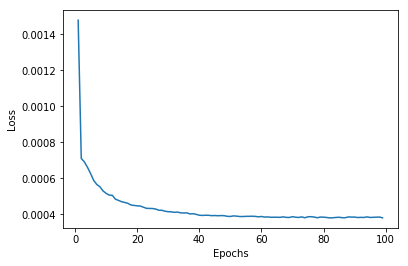

In [13]:
from matplotlib import pyplot as plt
learning =[]
for i in range(arguments.num_epochs):
    a = (len(loss_list)/arguments.num_epochs)*(i-1)
    b = (len(loss_list)/arguments.num_epochs)*(i)
    learning.append(np.mean(loss_list[a:b]))

plt.plot(learning)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Load models

In [11]:
#Modelo12
path_model = 'FO_UCY-UNIV_NON_12/model.ckpt-43800'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_test, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  1%|1         | 7/502 [00:00<00:07, 66.27it/s]

Evaluating


100%|##########| 502/502 [00:05<00:00, 89.20it/s]


{'ade': 0.65242285, 'fde': 1.4202468}


In [12]:
# Mejor Modelo
path_model = 'FO_UCY-UNIV_NON-BEST_12/model_best.ckpt-34200'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data_test, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  2%|1         | 8/502 [00:00<00:06, 76.26it/s]

Evaluating


100%|##########| 502/502 [00:05<00:00, 89.99it/s]


{'ade': 0.64995474, 'fde': 1.4131101}
